In [1]:
%matplotlib inline


# ANVIL nowcast

This example demonstrates how to use ANVIL and the advantages compared to
extrapolation nowcast and S-PROG.

Load the libraries.


In [2]:
from datetime import datetime, timedelta
import warnings

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
from pysteps import motion, io, rcparams, utils
from pysteps.nowcasts import anvil, extrapolation, sprog
from pysteps.utils import transformation
from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read the input data

ANVIL was originally developed to use vertically integrated liquid (VIL) as
the input data, but the model allows using any two-dimensional input fields.
Here we use a composite of rain rates.



In [3]:
date = datetime.strptime("201505151620", "%Y%m%d%H%M")

# Read the data source information from rcparams
data_source = rcparams.data_sources["mch"]

root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]

# Find the input files in the archive. Use history length of 5 timesteps
filenames = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep=5, num_prev_files=5
)

# Read the input time series
importer = io.get_method(importer_name, "importer")
rainrate_field, quality, metadata = io.read_timeseries(
    filenames, importer, **importer_kwargs
)

# Convert to rain rate (mm/h)
rainrate_field, metadata = utils.to_rainrate(rainrate_field, metadata)

## Compute the advection field

Apply the Lucas-Kanade method with the parameters given in Pulkkinen et al.
(2020) to compute the advection field.



In [4]:
fd_kwargs = {}
fd_kwargs["max_corners"] = 1000
fd_kwargs["quality_level"] = 0.01
fd_kwargs["min_distance"] = 2
fd_kwargs["block_size"] = 8

lk_kwargs = {}
lk_kwargs["winsize"] = (15, 15)

oflow_kwargs = {}
oflow_kwargs["fd_kwargs"] = fd_kwargs
oflow_kwargs["lk_kwargs"] = lk_kwargs
oflow_kwargs["decl_scale"] = 10

oflow = motion.get_method("lucaskanade")

# transform the input data to logarithmic scale
rainrate_field_log, _ = utils.transformation.dB_transform(
    rainrate_field, metadata=metadata
)
velocity = oflow(rainrate_field_log, **oflow_kwargs)

### Compute the nowcasts and threshold rain rates below 0.5 mm/h



In [5]:
forecast_extrap = extrapolation.forecast(
    rainrate_field[-1], velocity, 3, extrap_kwargs={"allow_nonfinite_values": True}
)
forecast_extrap[forecast_extrap < 0.5] = 0.0

# log-transform the data and the threshold value to dBR units for S-PROG
rainrate_field_db, _ = transformation.dB_transform(
    rainrate_field, metadata, threshold=0.1, zerovalue=-15.0
)
rainrate_thr, _ = transformation.dB_transform(
    np.array([0.5]), metadata, threshold=0.1, zerovalue=-15.0
)
forecast_sprog = sprog.forecast(
    rainrate_field_db[-3:], velocity, 3, n_cascade_levels=8, R_thr=rainrate_thr[0]
)
forecast_sprog, _ = transformation.dB_transform(
    forecast_sprog, threshold=-10.0, inverse=True
)
forecast_sprog[forecast_sprog < 0.5] = 0.0

forecast_anvil = anvil.forecast(
    rainrate_field[-4:], velocity, 3, ar_window_radius=25, ar_order=2
)
forecast_anvil[forecast_anvil < 0.5] = 0.0

Computing S-PROG nowcast:
-------------------------

Inputs:
-------
input dimensions: 640x710

Methods:
--------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters:
-----------
number of time steps:     3
parallel threads:         1
number of cascade levels: 8
order of the AR(p) model: 2
precip. intensity threshold: -3.0103
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.998538      | 0.994629      |
-----------------------------------------
| 2     | 0.998363      | 0.994110      |
-----------------------------------------
| 3     | 0.989118      | 0.961770      |
------------

### Read the reference observation field and threshold rain rates below 0.5 mm/h



In [6]:
filenames = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep=5, num_next_files=3
)

refobs_field, quality, metadata = io.read_timeseries(
    filenames, importer, **importer_kwargs
)

refobs_field, metadata = utils.to_rainrate(refobs_field[-1], metadata)
refobs_field[refobs_field < 0.5] = 0.0

## Plot the extrapolation, S-PROG and ANVIL nowcasts.

For comparison, the observed rain rate fields are also plotted. Growth and
decay areas are marked with red and blue circles, respectively.



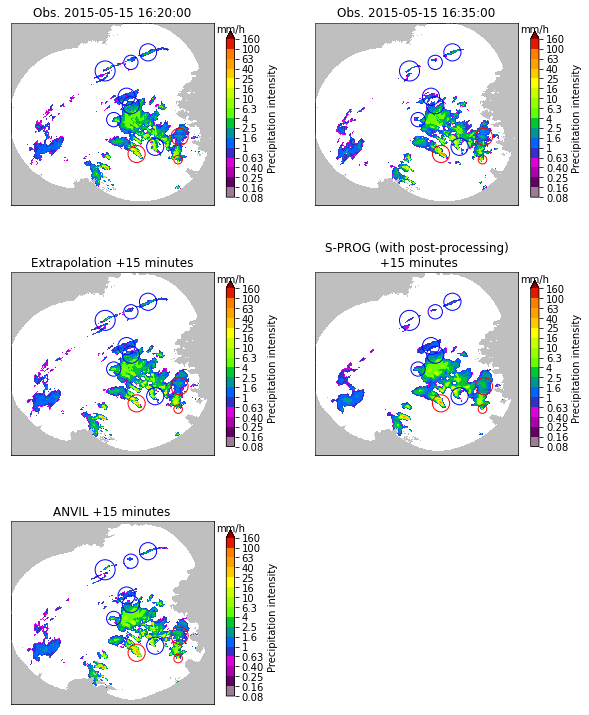

In [7]:
def plot_growth_decay_circles(ax):
    circle = plt.Circle(
        (360, 300), 25, color="b", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (420, 350), 30, color="b", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (405, 380), 30, color="b", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (420, 500), 25, color="b", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (480, 535), 30, color="b", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (330, 470), 35, color="b", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (505, 205), 30, color="b", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (440, 180), 30, color="r", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (590, 240), 30, color="r", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        (585, 160), 15, color="r", clip_on=False, fill=False, zorder=1e9
    )
    ax.add_artist(circle)


fig = plt.figure(figsize=(10, 13))

ax = fig.add_subplot(321)
rainrate_field[-1][rainrate_field[-1] < 0.5] = 0.0
plot_precip_field(rainrate_field[-1])
plot_growth_decay_circles(ax)
ax.set_title("Obs. %s" % str(date))

ax = fig.add_subplot(322)
plot_precip_field(refobs_field)
plot_growth_decay_circles(ax)
ax.set_title("Obs. %s" % str(date + timedelta(minutes=15)))

ax = fig.add_subplot(323)
plot_precip_field(forecast_extrap[-1])
plot_growth_decay_circles(ax)
ax.set_title("Extrapolation +15 minutes")

ax = fig.add_subplot(324)
plot_precip_field(forecast_sprog[-1])
plot_growth_decay_circles(ax)
ax.set_title("S-PROG (with post-processing)\n +15 minutes")

ax = fig.add_subplot(325)
plot_precip_field(forecast_anvil[-1])
plot_growth_decay_circles(ax)
ax.set_title("ANVIL +15 minutes")

plt.show()

## Remarks

The extrapolation nowcast is static, i.e. it does not predict any growth or
decay. While S-PROG is to some extent able to predict growth and decay, this
this comes with loss of small-scale features. In addition, statistical
post-processing needs to be applied to correct the bias and incorrect wet-area
ratio introduced by the autoregressive process. ANVIL is able to do both:
predict growth and decay and preserve the small-scale structure in a way that
post-processing is not necessary.

